<a href="https://colab.research.google.com/github/AlexyNat/ml/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №5. Алгоритмы кластеризации данных
## Общее задание

Перед выполнением лабораторной работы необходимо загрузить набор данных в соответствии с вариантом на диск.
1. Произвести масштабирование признаков (scaling).
2. С использованием библиотеки [scikit-learn](http://scikit-learn.org/stable/) написать программу с использованием алгоритмов кластеризации данных, позволяющую разделить исходную выборку на классы, соответствующие предложенной вариантом задаче (http://scikit-learn.org/stable/modules/clustering.html).
3. Провести эксперименты и определить наилучший алгоритм кластеризации, параметры алгоритма. Необходимо использовать не менее 3-х алгоритмов.
Данные экспериментов необходимо представить в отчете (графики, ход проведения эксперимента, выводы).

<h3>Вариант 23. Mice Protein Expression</h3>

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

data = pd.read_excel('sample_data/data.xlsx',sheet_name='Hoja1')
data = data.drop(['MouseID'], axis=1)
data['Genotype'] = data['Genotype'].replace({'Control': 0, 'Ts65Dn': 1})
data['Treatment'] = data['Treatment'].replace({'Saline': 0, 'Memantine': 1})
data['Behavior'] = data['Behavior'].replace({'S/C': 0, 'C/S': 1})

y_class = data['class']
y = data['class'].replace({'c-CS-m': 0, 'c-SC-m': 1, 'c-CS-s': 2, 'c-SC-s': 3, 't-CS-m': 4, 't-SC-m': 5, 't-CS-s': 6, 't-SC-s': 7})
data = data.drop(['class'], axis=1)

data = shuffle(data)
print(f"Shape: {data.shape}")
print(f"Class: {pd.unique(y_class)} - {len(pd.unique(y))}")

Shape: (1080, 80)
Class: ['c-CS-m' 'c-SC-m' 'c-CS-s' 'c-SC-s' 't-CS-m' 't-SC-m' 't-CS-s' 't-SC-s'] - 8


<h3>Заполнение пропущеных значений<h3>

In [ ]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imp.fit_transform(data)

<h3>Масштабирование данных</h3>

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(data, y, test_size=0.3)

<h3>K-means кластеризация</h3>

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


kmeans = KMeans(n_clusters=8, random_state=1).fit(data)

Text(0.5, 1.0, 'PCA')

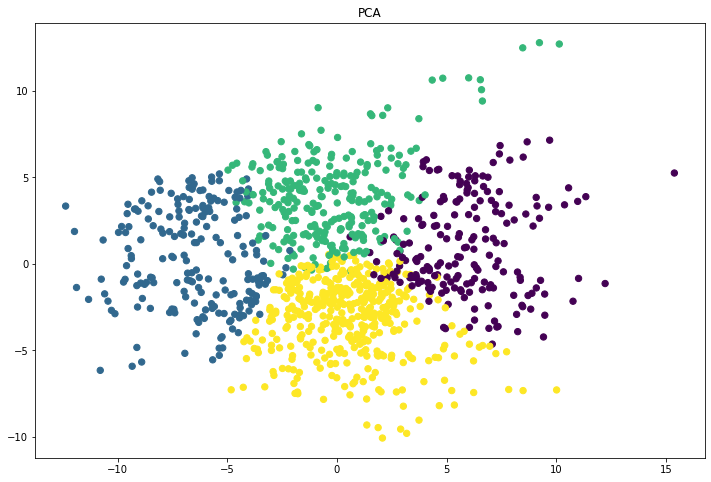

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
res = pca.fit_transform(data)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=40, cmap='viridis')
plt.title('PCA')

In [ ]:
inertia = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 16), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [ ]:
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn import metrics


algorithms = []
algorithms.append(KMeans(n_clusters=8, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=8, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=8))

data_t = []
for algo in algorithms:
    algo.fit(data)
    data_t.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(data, algo.labels_)}))

results = pd.DataFrame(data=data_t, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,-0.000584,-0.001106,0.000835,0.002539,0.001257,0.138609
Affinity,0.000517,0.001107,0.221876,0.097545,0.135513,0.281520
Spectral,-0.000390,0.000185,0.001691,0.005202,0.002552,0.112351
Agglomerative,0.000219,-0.000746,0.001082,0.003490,0.001652,0.122813
